In [1]:
import pycrfsuite

In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
from _chain import Chain

### Define Binary HMM 

In [21]:
def f_phi(x1, x2):
    p = np.array([
    [0.58, 0.42],
    [0.42, 0.58]])
    return p[x1, x2]

In [31]:
def f_psi(x1, x2):
    p = np.array([
    [0.62, 0.38],
    [0.34, 0.66]])
    return p[x1, x2]

In [32]:
phi = f_phi
psi = f_psi

In [33]:
T = 50 # chain length

In [34]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [35]:
possible_values = [0, 1]

In [36]:
N = 1000

In [37]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 2.15 s, sys: 18 ms, total: 2.16 s
Wall time: 2.15 s


In [38]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

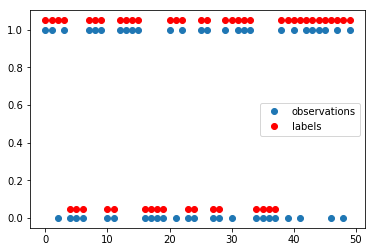

In [39]:
plot(X_dataset[-1], 'o')
plot(y_dataset[-1] + 0.05, 'ro')
legend(['observations', 'labels'])

### Play with HMM implementation

In [40]:
import mchmm as mc
hmm = mc.HiddenMarkovModel()

In [41]:
ep = np.array([
    [0.62, 0.38],
    [0.38, 0.62]])

In [42]:
tp = np.array([
    [0.62, 0.38],
    [0.38, 0.62]])

In [39]:
hmm.observations = hmm.states = np.array([0, 1])

In [106]:
pi = np.array([0.5, 0.5])

In [107]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = np.array(1 * (x > 0.5))
    
    y = hmm.viterbi(x_binary, tp=tp, ep=ep, pi=pi)[0]

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 1.81 s, sys: 9.26 ms, total: 1.82 s
Wall time: 1.82 s


In [108]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

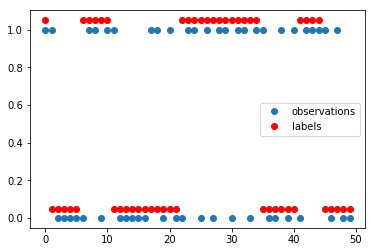

In [109]:
plot(X_dataset[0], 'o')
plot(y_dataset[0] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train Dummy Model (predicts y = x)

#### Train-Test split

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Evaluate 

In [315]:
y_pred = X_test

In [316]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4930
           1       0.69      0.68      0.68      5070

   micro avg       0.68      0.68      0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



### Train CRF

In [43]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [44]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [45]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [47]:
trainer = pycrfsuite.Trainer(verbose=True)

In [48]:
# Submit training data to the trainer
trainer.clear()
    
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [49]:
rm crf.model

In [50]:
# the model will be saved under 'crf.model'
trainer.train('crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 7
Seconds required: 0.006

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 16096.359684
Feature norm: 1.000000
Error norm: 11267.948020
Active features: 7
Line search trials: 1
Line search step: 0.000058
Seconds required for this iteration: 0.009

***** Iteration #2 *****
Loss: 8354.481112
Feature norm: 2.276286
Error norm: 6142.481414
Active features: 7
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.007

***** Iteration #3 *****
Loss: 5925.458608
Feature norm: 3.028433
Error norm: 3008.127288
Active features: 7
Line search trials: 1
Line search step: 1.000000
Seconds required for this iterati

####  Evaluate

In [51]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')

y_pred = [tagger.tag(xseq) for xseq in X_test]

In [52]:
# Create a mapping of labels to indices
labels = {"0": 0, "1": 1}

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3834
           1       1.00      1.00      1.00      6166

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Try using sklearn.CRF wrapper

In [348]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [349]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=1000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 285 ms, sys: 7.24 ms, total: 292 ms
Wall time: 291 ms


In [350]:
y_pred = crf.predict(X_test)

In [351]:
labels = list(crf.classes_)
labels

['0', '1']

In [352]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      0.961     1.000     0.980      5008
           1      1.000     0.959     0.979      4992

   micro avg      0.980     0.980     0.980     10000
   macro avg      0.981     0.980     0.980     10000
weighted avg      0.980     0.980     0.980     10000



In [353]:
crf

CRF(algorithm='lbfgs', all_possible_states=True,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=1000,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [354]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
0      -> 0       1.741105
1      -> 1       1.731125
0      -> 1       -1.914187
1      -> 0       -1.938501


In [355]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
0.869181 1        x.current=1
0.865415 0        x.current=0
-0.865415 1        x.current=0
-0.869181 0        x.current=1


In [356]:
import scipy
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [357]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.2s finished


CPU times: user 55.4 s, sys: 600 ms, total: 56 s
Wall time: 56.5 s


In [358]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 2.601810142324518, 'c2': 0.13253074750872607}
best CV score: 0.9714514252075627
model size: 0.00M


### Training FC NN 

#### Define 

In [64]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [65]:
n_epochs = 1000
batch_size, D_in, D_hidden, D_out = 64, T, 2 * T, T

In [66]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Sigmoid()
        )

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [67]:
from torch.utils.data import Dataset

class ChainDataset(Dataset):
    
    def __init__(self, X, y, flatten=True):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        sample = {
            'X': torch.from_numpy(self._X[idx]).float(),
            'y': torch.from_numpy(self._y[idx]).float()  
        }
        return sample

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

In [69]:
trainset = ChainDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#### Train 

In [70]:
model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        model.zero_grad()
        
        y_pred = model(X_batch)
        loss = F.binary_cross_entropy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('epoch {}:: loss = {}'. format(epoch, loss))
        learning_curve.append(loss)

epoch 10:: loss = 0.2114993929862976
epoch 20:: loss = 0.13857434689998627
epoch 30:: loss = 0.08925817161798477
epoch 40:: loss = 0.08183830976486206
epoch 50:: loss = 0.07915858179330826
epoch 60:: loss = 0.05572351813316345
epoch 70:: loss = 0.043237730860710144
epoch 80:: loss = 0.04118090122938156
epoch 90:: loss = 0.030093984678387642
epoch 100:: loss = 0.033441200852394104
epoch 110:: loss = 0.020153027027845383
epoch 120:: loss = 0.018369480967521667
epoch 130:: loss = 0.018003512173891068
epoch 140:: loss = 0.013446403667330742
epoch 150:: loss = 0.012158852070569992
epoch 160:: loss = 0.009657088667154312
epoch 170:: loss = 0.008416078984737396
epoch 180:: loss = 0.006717754062265158
epoch 190:: loss = 0.006864999420940876
epoch 200:: loss = 0.005505006294697523
epoch 210:: loss = 0.005018127150833607
epoch 220:: loss = 0.004055824130773544
epoch 230:: loss = 0.003597445087507367
epoch 240:: loss = 0.003289749613031745
epoch 250:: loss = 0.0030104259494692087
epoch 260:: loss

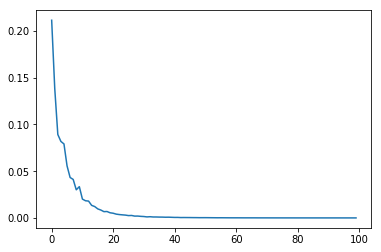

In [71]:
plot(learning_curve);

#### Evaluate 

In [72]:
model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
)

In [73]:
y_pred = np.array([model(torch.from_numpy(xseq).float()).detach().numpy() for xseq in X_test])

In [74]:
y_pred = 1 * (y_pred > 0.5)

In [75]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5933
           1       0.90      0.87      0.89      4067

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Create dataset from trained CRF

In [30]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')

y_pred_test = [tagger.tag(xseq) for xseq in X_test]
y_pred_train = [tagger.tag(xseq) for xseq in X_train]

#### Train new CRF over the generated dataset

In [31]:
chain.update_observed([int(c[0].split('=')[1]) for c in X_train[0]])
y_chain = chain.get_max_apostriori_beliefs()

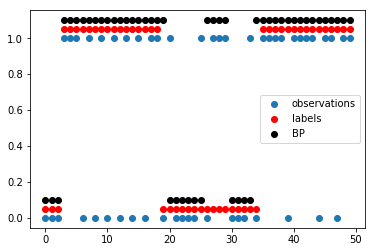

In [32]:
plot([int(c[0].split('=')[1]) for c in X_train[0]], 'o')
plot([int(c) + 0.05 for c in y_pred_train[0]], 'ro')
plot(np.array(y_chain) + 0.1, 'ko')
legend(['observations', 'labels', 'BP'])

In [ ]:
trainer = pycrfsuite.Trainer(verbose=True)

In [ ]:
# Submit training data to the trainer
trainer.clear()
    
for xseq, yseq in zip(X_train, y_pred_train):
    trainer.append(xseq, yseq)

In [ ]:
# the model will be saved under 'crf.model'
trainer.train('crf_from_crf_created_data.model')

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open('crf_from_crf_created_data.model')

y_pred = [tagger.tag(xseq) for xseq in X_test]

In [ ]:
labels = {"0": 0, "1": 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_pred_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

In [191]:
data = {(0.5, 0.5, 0.5): 9.595693779904307,
 (0.5, 0.5, 0.6): 8.222488038277513,
 (0.5, 0.5, 0.7): 6.7990430622009566,
 (0.5, 0.5, 0.8): 5.375598086124402,
 (0.5, 0.5, 0.85): 4.538277511961723,
 (0.5, 0.6, 0.5): 8.858851674641148,
 (0.5, 0.6, 0.6): 7.6196172248803835,
 (0.5, 0.6, 0.7): 6.246411483253588,
 (0.5, 0.6, 0.8): 4.940191387559809,
 (0.5, 0.6, 0.85): 4.1028708133971294,
 (0.5, 0.7, 0.5): 8.172248803827753,
 (0.5, 0.7, 0.6): 7.033492822966506,
 (0.5, 0.7, 0.7): 5.794258373205741,
 (0.5, 0.7, 0.8): 4.488038277511961,
 (0.5, 0.7, 0.85): 3.767942583732057,
 (0.5, 0.75, 0.5): 7.70334928229665,
 (0.5, 0.75, 0.6): 6.681818181818182,
 (0.5, 0.75, 0.7): 5.509569377990431,
 (0.5, 0.75, 0.8): 4.287081339712919,
 (0.5, 0.75, 0.85): 3.5669856459330145,
 (0.6, 0.5, 0.5): 7.569377990430622,
 (0.6, 0.5, 0.6): 6.514354066985646,
 (0.6, 0.5, 0.7): 5.342105263157895,
 (0.6, 0.5, 0.8): 4.287081339712919,
 (0.6, 0.5, 0.85): 3.583732057416268,
 (0.6, 0.6, 0.5): 7.033492822966506,
 (0.6, 0.6, 0.6): 6.078947368421053,
 (0.6, 0.6, 0.7): 4.940191387559809,
 (0.6, 0.6, 0.8): 3.9856459330143537,
 (0.6, 0.6, 0.85): 3.299043062200957,
 (0.6, 0.7, 0.5): 6.464114832535886,
 (0.6, 0.7, 0.6): 5.626794258373206,
 (0.6, 0.7, 0.7): 4.57177033492823,
 (0.6, 0.7, 0.8): 3.6339712918660285,
 (0.6, 0.7, 0.85): 3.047846889952153,
 (0.6, 0.75, 0.5): 6.078947368421053,
 (0.6, 0.75, 0.6): 5.342105263157895,
 (0.6, 0.75, 0.7): 4.337320574162679,
 (0.6, 0.75, 0.8): 3.4665071770334928,
 (0.6, 0.75, 0.85): 2.8971291866028706,
 (0.7, 0.5, 0.5): 6.062200956937799,
 (0.7, 0.5, 0.6): 5.291866028708133,
 (0.7, 0.5, 0.7): 4.169856459330144,
 (0.7, 0.5, 0.8): 3.148325358851675,
 (0.7, 0.5, 0.85): 2.6459330143540667,
 (0.7, 0.6, 0.5): 5.64354066985646,
 (0.7, 0.6, 0.6): 4.973684210526316,
 (0.7, 0.6, 0.7): 3.851674641148325,
 (0.7, 0.6, 0.8): 2.8971291866028706,
 (0.7, 0.6, 0.85): 2.4449760765550237,
 (0.7, 0.7, 0.5): 5.124401913875598,
 (0.7, 0.7, 0.6): 4.555023923444976,
 (0.7, 0.7, 0.7): 3.5502392344497604,
 (0.7, 0.7, 0.8): 2.5956937799043063,
 (0.7, 0.7, 0.85): 2.227272727272727,
 (0.7, 0.75, 0.5): 4.80622009569378,
 (0.7, 0.75, 0.6): 4.337320574162679,
 (0.7, 0.75, 0.7): 3.3660287081339715,
 (0.7, 0.75, 0.8): 2.4952153110047846,
 (0.7, 0.75, 0.85): 2.126794258373206,
 (0.8, 0.5, 0.5): 4.035885167464114,
 (0.8, 0.5, 0.6): 3.5334928229665072,
 (0.8, 0.5, 0.7): 2.8636363636363638,
 (0.8, 0.5, 0.8): 2.0933014354066986,
 (0.8, 0.5, 0.85): 1.825358851674641,
 (0.8, 0.6, 0.5): 3.8014354066985647,
 (0.8, 0.6, 0.6): 3.332535885167464,
 (0.8, 0.6, 0.7): 2.6291866028708135,
 (0.8, 0.6, 0.8): 1.9258373205741626,
 (0.8, 0.6, 0.85): 1.674641148325359,
 (0.8, 0.7, 0.5): 3.416267942583732,
 (0.8, 0.7, 0.6): 3.0143540669856463,
 (0.8, 0.7, 0.7): 2.4449760765550237,
 (0.8, 0.7, 0.8): 1.7751196172248802,
 (0.8, 0.7, 0.85): 1.5406698564593302,
 (0.8, 0.75, 0.5): 3.1985645933014353,
 (0.8, 0.75, 0.6): 2.84688995215311,
 (0.8, 0.75, 0.7): 2.327751196172249,
 (0.8, 0.75, 0.8): 1.708133971291866,
 (0.8, 0.75, 0.85): 1.4569377990430623,
 (0.9, 0.5, 0.5): 1.8086124401913877,
 (0.9, 0.5, 0.6): 1.4401913875598085,
 (0.9, 0.5, 0.7): 1.055023923444976,
 (0.9, 0.5, 0.8): 0.6196172248803828,
 (0.9, 0.5, 0.85): 0.5191387559808612,
 (0.9, 0.6, 0.5): 1.708133971291866,
 (0.9, 0.6, 0.6): 1.4066985645933014,
 (0.9, 0.6, 0.7): 1.0047846889952152,
 (0.9, 0.6, 0.8): 0.5861244019138756,
 (0.9, 0.6, 0.85): 0.4856459330143541,
 (0.9, 0.7, 0.5): 1.5239234449760766,
 (0.9, 0.7, 0.6): 1.2727272727272727,
 (0.9, 0.7, 0.7): 0.9210526315789473,
 (0.9, 0.7, 0.8): 0.5023923444976076,
 (0.9, 0.7, 0.85): 0.4354066985645933,
 (0.9, 0.75, 0.5): 1.3732057416267942,
 (0.9, 0.75, 0.6): 1.1555023923444976,
 (0.9, 0.75, 0.7): 0.8205741626794258,
 (0.9, 0.75, 0.8): 0.4521531100478469,
 (0.9, 0.75, 0.85): 0.3684210526315789}

In [192]:
import pandas as pd

In [211]:
df = pd.DataFrame([], columns=['exp', 'p_audio', 'p_raising', 'p_raised', 'FA'])

In [212]:
i = 1
for k, v in data.items():
    row = pd.DataFrame([[i, k[0], k[1], k[2], v]], columns=['exp', 'p_audio', 'p_raising', 'p_raised', 'FA'])
    df = df.append(row)        
    i += 1

In [214]:
df

,exp,p_audio,p_raising,p_raised,FA
0,1,0.5,0.50,0.50,9.595694
0,2,0.5,0.50,0.60,8.222488
0,3,0.5,0.50,0.70,6.799043
0,4,0.5,0.50,0.80,5.375598
0,5,0.5,0.50,0.85,4.538278
0,6,0.5,0.60,0.50,8.858852
0,7,0.5,0.60,0.60,7.619617
0,8,0.5,0.60,0.70,6.246411
0,9,0.5,0.60,0.80,4.940191
0,10,0.5,0.60,0.85,4.102871


In [227]:

import plotly.express as px
fig = px.scatter(df, x="exp", y="FA", color="p_audio",
                 hover_data=['p_audio', 'p_raising', 'p_raised'])
fig.show()

In [226]:

import plotly.express as px
fig = px.scatter_3d(df, x="p_audio", y="p_raising", z="p_raised", color="FA", size='FA',
                 hover_data=['p_audio', 'p_raising', 'p_raised'])
fig.write_html('3d_figure.html', auto_open=True)
